Training of model which has prediction noise in the image ability. 

## IMPORTS

In [9]:
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Dropout,Conv2D,Conv2DTranspose,Activation,Flatten,LeakyReLU # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.models import Model,load_model# type: ignore
from IPython.display import clear_output
import tensorflow.keras.backend as K# type: ignore
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import numpy as np
import tqdm
import time
import cv2
import gc
import os

In [10]:
global IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL,BATCH_SIZE,EPOCHS,IMAGES_PATH
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300
IMAGE_CHANNEL = 3
BATCH_SIZE = 4
SEGMENT_PER_IMAGE = 8
EPOCHS = 100
AUTO_SAVE_PERIOT = 5
TRAIN_TOPIC = datetime.now().strftime("%m_%d-%H_%M")

DATA_LIMIT = 200
IMAGES_PATH = './images_1'
TEST_IMAGES_PATH = './images_2'
BATCH_COUNT = int(DATA_LIMIT / BATCH_SIZE * SEGMENT_PER_IMAGE)

global clear_losses,clear_accs,noisy_losses,noisy_accs
clear_losses,clear_accs,noisy_losses,noisy_accs = [],[],[],[]

In [11]:
tf.config.list_physical_devices()
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

## DATA

### PREPROCESS

In [12]:
def add_loud(image,noise_mean=20,noise_std=50,say=False):
    """
    Adds noise to image
    input:
        image
    return:
        noisy_image: noise added original image
        noise: noise map which added
    """
    noise = np.clip(np.random.normal(20,50,image.shape).astype(np.float32),-255,255)
    noisy = image + noise
    
    high_mask = np.clip(noisy,255,510) - 255
    lower_mask = np.clip(noisy,-255,0)
    mixed_mask = high_mask + lower_mask
    new_noise = noise - mixed_mask
    
    
    new_noisy = image + new_noise
    if say:
        def _say(im):
            print()
            print(im.dtype)
            print("MAX:",im.max())
            print("MIN:",im.min())
    
        for i in [noise,noisy,lower_mask,high_mask,mixed_mask,new_noise,new_noisy]:
            _say(i)
    return np.uint8(new_noisy),np.uint8(new_noise)
    

    
def scale_im(im):
    im = im / 255
    return im

def descale_im(im):
    im = im * 255
    im = im.astype(np.uint8)

    min_val = im.min()
    max_val = im.max()

    if min_val < 0 or max_val > 255:    
        # 0 ile 255 arasında ölçekleme yap
        im = ((im - min_val) / (max_val - min_val) * 255).astype('uint8')
        
    return im

### DATA LOADING

In [13]:
## total data file size
total = 0
TOTAL_DATA_COUNT = 0
for i in os.listdir(IMAGES_PATH)[:DATA_LIMIT]:
    path = f"{IMAGES_PATH}/{i}"
    size = os.path.getsize(path)
    total += size
    TOTAL_DATA_COUNT +=1

print(f"DATASET SIZE: {total / (1024 * 1024):.2f} MB")  # Megabyte
print(f"TOTAL DATA COUNT: {TOTAL_DATA_COUNT}")

DATASET SIZE: 52.53 MB
TOTAL DATA COUNT: 200


In [14]:
def segment_im(im, sub_im_width=300, sub_im_height=300):
    im_height, im_width = im.shape[0], im.shape[1]
    
    segments = []
    
    for h_i in range(int(im_height / sub_im_height)):
        for j_i in range(int(im_width / sub_im_width)):
            segment = im[h_i * sub_im_height:(h_i + 1) * sub_im_height, j_i * sub_im_width:(j_i + 1) * sub_im_width]
            segments.append(segment)
    
    return segments

def corner_segment_im(im, sub_im_width=1200, sub_im_height=600):
    shape = tf.shape(im)  
    im_height, im_width = shape[0], shape[1]

    top_left = im[0:sub_im_height, 0:sub_im_width]    
    top_right = im[0:sub_im_height, im_width-sub_im_width:im_width]    
    bottom_left = im[im_height-sub_im_height:im_height, 0:sub_im_width]    
    bottom_right = im[im_height-sub_im_height:im_height, im_width-sub_im_width:im_width]   

    return [top_left, top_right, bottom_left, bottom_right]

def load_dataset():        
    names = os.listdir(IMAGES_PATH)[:DATA_LIMIT]
    image_paths = list(f"{IMAGES_PATH}/{name}" for name in names)
 
    images = []
    for image_path in tqdm.tqdm(image_paths):
        image = cv2.imread(image_path)
        corner_segments = corner_segment_im(image)
        for cornet_segment in corner_segments:
            segments = segment_im(cornet_segment)
            for segment in segments:
                images.append(segment)

    images = np.array(images)
    print("DATASET",images.shape)
    return np.array(images)

def get_slice(data,start_idx,end_idx):
    images = data[start_idx:end_idx]
    origs,noisies,noises,clears = [],[],[],[]
    for i,orig in enumerate(images):
        noisy,noise = add_loud(orig)
        noisies.append(scale_im(noisy))
        noises.append(scale_im(noise))
        origs.append(scale_im(orig))
    origs = np.array(origs)
    noisies = np.array(noisies)
    noises = np.array(noises)
    
    clears = np.ones_like(images) * 0.01
    
    return origs,clears,noisies,noises


## MODEL

In [95]:
def create_model():
    inp = Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL))

    x = Conv2D(32,(5,5),(2,2),padding='same', kernel_initializer='he_normal')(inp)
    x = Activation("relu")(x)

    x = Conv2D(64,(3,3),(2,2),padding='same', kernel_initializer='he_normal')(x)
    x = Activation("relu")(x)

    x = Conv2DTranspose(64,(3,3),(2,2),padding='same', kernel_initializer='he_normal')(x)
    x = Activation("relu")(x)
    
    x = Conv2DTranspose(32,(3,3),(2,2),padding='same', kernel_initializer='he_normal')(x)
    x = Activation("relu")(x)
    
    x = Conv2DTranspose(32,(5,5),(2,2),padding='same', kernel_initializer='he_normal',activation='sigmoid')(x)
    x = Activation("relu")(x)
    
    out = Conv2D(3,(3,3),(2,2),padding='same', kernel_initializer='he_normal')(x)

    return Model(inp,out,name='noisier_model')

opt = Adam(learning_rate=1e-03,beta_1=0.5)
model = create_model()
model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "noisier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 75, 75, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 150, 150, 64)     36928     
 nspose)                                                         
                                                     

## TRAINING

In [96]:
def save_checkpoint(epoch,model,clear_loss,clear_acc,noisy_loss,noisy_acc,interval_test_sample):

    model.save(f'./training/noise-predictor/{TRAIN_TOPIC}_{epoch}.h5')
    
    # metrics save
    f = open('./training/noise-predictor-checkpoint.txt','a')
    f.writelines(f"\ntrain:{TRAIN_TOPIC} epoch:{epoch} clear_loss:{clear_loss:.7f} noisy_loss:{noisy_loss:.7f} clear_acc:{clear_acc:.7f} noisy_acc:{noisy_acc}")
    f.close()

    # sample save
    cv2.imwrite(f'./training/samples/{TRAIN_TOPIC}_{epoch}.jpg',interval_test_sample)

def interval_test(model,orig_im):
    noisy_im,noise = add_loud(orig_im)
    
    noisy_im = scale_im(noisy_im)
    orig_im = scale_im(np.uint8(orig_im))

    noisy_im = np.expand_dims(noisy_im,axis=0)
    orig_im = np.expand_dims(orig_im,axis=0)
    
    orig_est =model.predict(orig_im)
    noisy_est = model.predict(noisy_im)

    orig_im = descale_im(np.reshape(orig_im,newshape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))
    orig_est = descale_im(np.reshape(orig_est,newshape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))
    noisy_im = descale_im(np.reshape(noisy_im,newshape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))
    noisy_est = descale_im(np.reshape(noisy_est,newshape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))

    sample = np.zeros((IMAGE_HEIGHT*2,IMAGE_WIDTH*2,3), dtype=np.uint8)
    sample[0:IMAGE_HEIGHT,0:IMAGE_WIDTH] = orig_im
    sample[0:IMAGE_HEIGHT,IMAGE_WIDTH:IMAGE_WIDTH*2] = noisy_im
    sample[IMAGE_HEIGHT:IMAGE_HEIGHT*2,0:IMAGE_WIDTH] =orig_est.astype(np.uint8)
    sample[IMAGE_HEIGHT:IMAGE_HEIGHT*2,IMAGE_WIDTH:IMAGE_WIDTH*2] = noisy_est.astype(np.uint8)


    return sample

def show_outputs(clear_losses,clear_accs,noisy_losses,noisy_accs,interval_test_sample):
    epochs_history = range(len(clear_losses))

    plt.figure(figsize=(10,7))    
    plt.imshow(cv2.cvtColor(interval_test_sample,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Test')
    plt.show()

    # Subplot figürü oluştur (2 satır, 1 sütun)
    fig, axes = plt.subplots(2, 1, figsize=(10, 7))
    
    # Loss grafiği (Üstte)
    axes[0].plot(epochs_history, clear_losses, label='Clear Losses', color='blue', marker='o')
    axes[0].plot(epochs_history, noisy_losses, label='Noisy Losses', color='green', marker='s')
    axes[0].set_title('Loss History')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy grafiği (Altta)
    axes[1].plot(epochs_history, clear_accs, label='Clear Accuracies', color='blue', marker='o')
    axes[1].plot(epochs_history, noisy_accs, label='Noisy Accuracies', color='green', marker='s')
    axes[1].set_title('Accuracy History')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # Aralarındaki boşlukları ayarla
    plt.tight_layout()
    
    # Grafiği göster
    plt.show()
        



In [97]:

def train(model,dataset):
    tf.keras.backend.clear_session()

    for i in tqdm.tqdm(range(EPOCHS)):
        ep_start_time = time.time()
        ep_clear_loss,ep_clear_acc,ep_noisy_loss,ep_noisy_acc = 0,0,0,0
        
        counter = 0
        for j in tqdm.tqdm(range(BATCH_COUNT)):

            orig_batch,clear_batch,noisy_batch,noise_batch = get_slice(dataset,i*BATCH_SIZE,(i+1)*BATCH_SIZE)
            
         
            # new training
            noisy_loss, noisy_acc = model.train_on_batch(orig_batch,orig_batch)
            clear_loss, clear_acc = model.train_on_batch(noisy_batch,orig_batch)
            #training
            """
            clear_loss,clear_acc = model.train_on_batch(noisy_batch,noise_batch)
            #noisy_loss,noisy_acc = model.train_on_batch(orig_batch,clear_batch)
            """

            #metrics
            ep_clear_loss += clear_loss
            ep_clear_acc += clear_acc
            ep_noisy_loss += noisy_loss
            ep_noisy_acc += noisy_acc
            counter += 1

        ep_clear_acc = ep_clear_acc / counter
        ep_clear_loss = ep_clear_loss / counter
        ep_noisy_acc = ep_noisy_acc / counter
        ep_noisy_loss = ep_noisy_loss / counter
        clear_losses.append(ep_clear_loss)
        clear_accs.append(ep_clear_acc)
        noisy_losses.append(ep_noisy_loss)
        noisy_accs.append(ep_noisy_acc)
        
        # Bellek temizliği
        gc.collect()
        K.clear_session()
        
        clear_output()
        test_im = dataset[0]
        interval_test_sample = interval_test(model,test_im)
        show_outputs(clear_losses,clear_accs,noisy_losses,noisy_accs,interval_test_sample) 

        print("EPOCH:",i)
        print("MODEL_CLEAR,ACC: ",ep_clear_acc,"  LOSS: ",ep_clear_loss)
        print("MODEL_NOISY,ACC:",ep_noisy_acc,"  LOSS",ep_noisy_loss)
        print("USED VRAM MEMORY: ",tf.config.experimental.get_memory_info('GPU:0'))  # VRAM bilgisi
        print("ELAPSED TIME: ",time.time()-ep_start_time)
        # save
        if i % AUTO_SAVE_PERIOT == 0:
            save_checkpoint(counter,model,ep_clear_loss,ep_clear_acc,ep_noisy_loss,ep_noisy_acc,interval_test_sample)
            
        if i == EPOCHS-1:
            plt.savefig(f'./{TRAIN_TOPIC}_results.png')

    return model,clear_losses,clear_accs,noisy_losses,noisy_accs

### TRAIN

In [98]:
dataset= load_dataset()

100%|██████████| 200/200 [00:03<00:00, 58.32it/s]


DATASET (6400, 300, 300, 3)


1/1 [==============================] - 0s 19ms/step


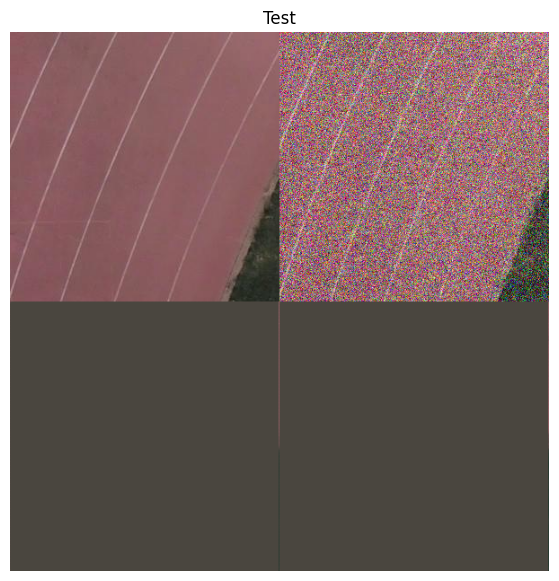

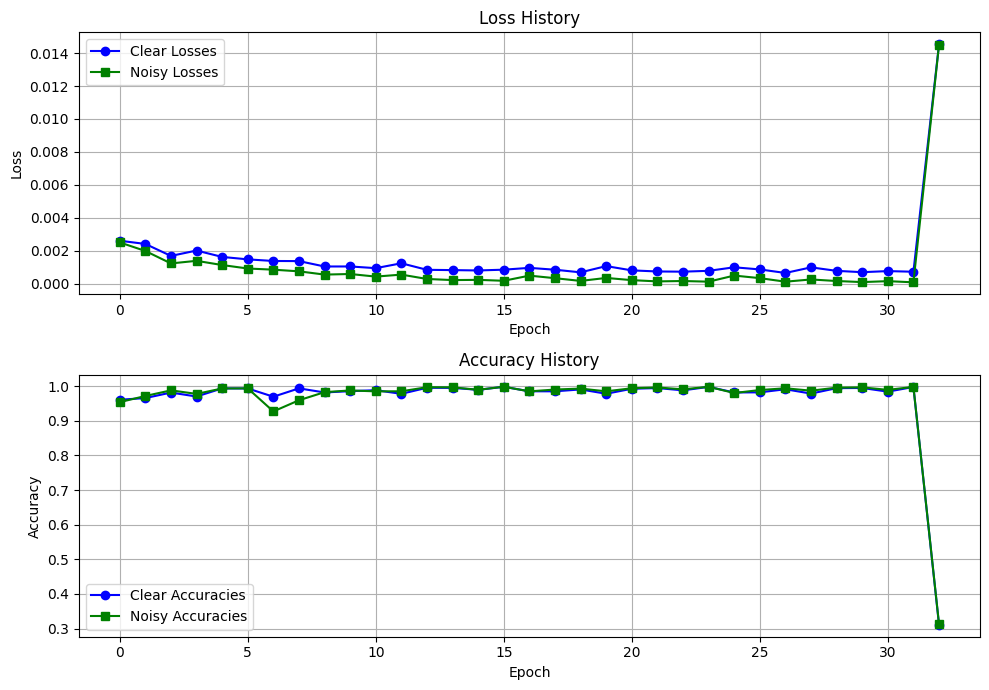

 33%|███▎      | 33/100 [1:13:32<2:25:17, 130.12s/it]

EPOCH: 32
MODEL_CLEAR,ACC:  0.31065908931195735   LOSS:  0.014536201981827616
MODEL_NOISY,LOSS - ACC: 0.31239168021827934   0.014502687577914912
USED VRAM MEMORY:  {'current': 3008256, 'peak': 1603489280}
ELAPSED TIME:  129.8564326763153


 33%|███▎      | 33/100 [1:14:11<2:30:37, 134.89s/it]


KeyboardInterrupt: 

In [99]:
model,clear_losses,clear_accs,noisy_losses,noisy_accs = train(model,dataset)

## TRANSFER

In [15]:
model = load_model("./training/noise-predictor/01_30-18_55_400.h5")

In [16]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [17]:
model.optimizer.learning_rate = 0.0005

## TESTS

In [18]:
def test_im(model,image,inter_width=1200,inter_height=600,sub_width=300,sub_height=300):
    width_count = int(inter_width / sub_width)
    height_count = int(inter_height / sub_height)
    
    image = scale_im(image)
    
    corners = corner_segment_im(image)

    corners_ims = []
    for corner_im in corners:    
        segments = segment_im(corner_im)
        segments = np.array(segments)
        outputs = model.predict(segments)
        outputs = np.reshape(outputs,(height_count,width_count,sub_width,sub_height,3))
        for i,row in enumerate(outputs):
            for j,output in enumerate(row):
                corner_im[i*sub_height:(i+1)*sub_height,j*sub_width:(j+1)*sub_width] = descale_im(output)
        corners_ims.append(corner_im)
    
    corners_ims = np.reshape(corners_ims,(2,2,inter_height,inter_width,3))
    output_image = image.copy()
    
    for i in range(2):
        for j in range(2):
            output_image[i*inter_height:(i+1)*inter_height,j*inter_width:(j+1)*inter_width] = corners_ims[i,j][:inter_height,:inter_width]
    
    return output_image
    

        
        
    
    
    



In [19]:
def test_im2(model,image,sub_width=300,sub_height=300):
    image = cv2.resize(image,(1800,900))
    out = image.copy()
    width_count = int(1800 / sub_width)
    height_count = int(900 / sub_height)
    image = scale_im(image)
    segments = segment_im(image)
    segments = np.array(segments)
    segments = np.reshape(segments,(height_count,width_count,sub_width,sub_height,3))
    for i,row in enumerate(segments):
        row_out = model.predict(row)
        for j,output in enumerate(row_out):
            out[i*sub_height:(i+1)*sub_height,j*sub_width:(j+1)*sub_width] = descale_im(output)

    return out
    

In [24]:
name = os.listdir(IMAGES_PATH)[0]
image_path = f"{IMAGES_PATH}/{name}"
test_image = cv2.imread(image_path)
estimation = test_im2(model,test_image)

1/1 [==============================] - 0s 20ms/step


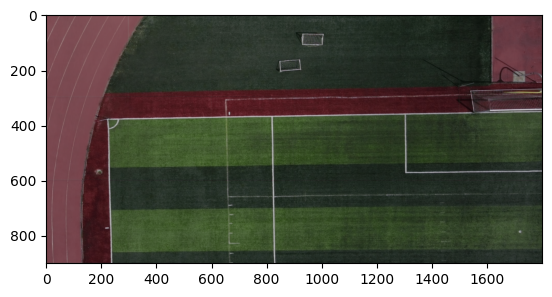

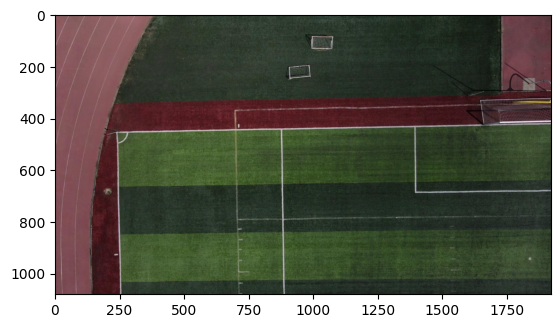

In [25]:
plt.imshow(cv2.cvtColor(estimation,cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB))
plt.show()

1/1 [==============================] - 0s 22ms/step


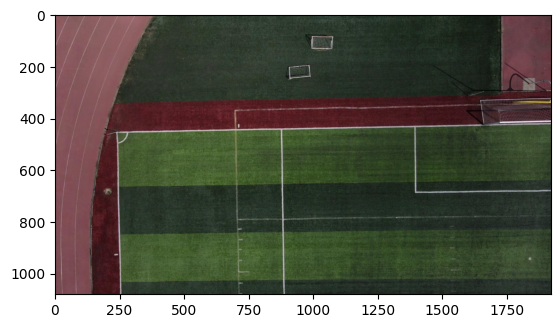

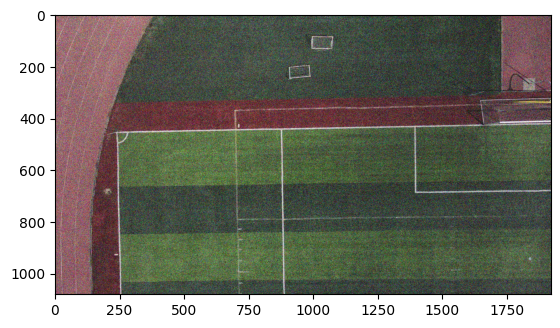

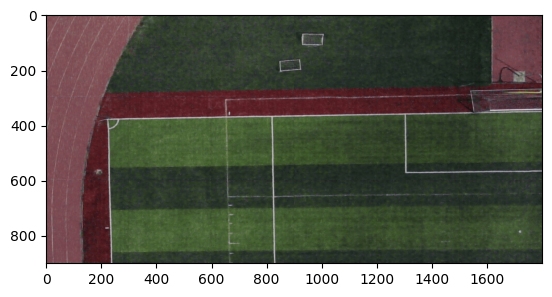

In [26]:
noisy_test_image = add_loud(test_image)[0]
estimation = test_im2(model,noisy_test_image)

plt.imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(noisy_test_image,cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(estimation,cv2.COLOR_BGR2RGB))
plt.show()

In [41]:
def load_test_dataset(data_limit):        
    names = os.listdir(TEST_IMAGES_PATH)[:data_limit]
    image_paths = list(f"{TEST_IMAGES_PATH}/{name}" for name in names)
 
    images = []
    for image_path in tqdm.tqdm(image_paths):
        image = cv2.imread(image_path)
        images.append(image)
    images = np.array(images)
    print("DATASET",images.shape)
    return np.array(images)

images = load_test_dataset(10)
print(images.shape)

noisies = np.array([add_loud(image)[0] for image in tqdm.tqdm(images)])

100%|██████████| 10/10 [00:00<00:00, 81.57it/s]


DATASET (10, 1080, 1920, 3)
(10, 1080, 1920, 3)


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


In [43]:
ev_ims = []
ev_nos = []

for image,noisy in tqdm.tqdm(zip(images,noisies)):

    image = cv2.resize(image,(1800,900))
    image = scale_im(image)
    im_segments = segment_im(image)
    
    noisy = cv2.resize(noisy,(1800,900))
    noisy = scale_im(noisy)
    noisy_segments = segment_im(noisy)
    for i in im_segments:
        ev_ims.append(i)
    for i in noisy_segments:
        ev_nos.append(i)
        
ev_ims = np.array(ev_ims)
ev_nos = np.array(ev_nos)

k = model.evaluate(ev_nos,ev_ims,batch_size=4,verbose=1)

10it [00:00, 30.19it/s]


 1/45 [..............................] - ETA: 1:12 - loss: 9.2392e-04 - accuracy: 0.9803

ResourceExhaustedError: Graph execution error:

Detected at node 'noisier_model/conv2d_transpose_2/conv2d_transpose' defined at (most recent call last):
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\asus\AppData\Local\Temp\ipykernel_19880\979043721.py", line 21, in <module>
      k = model.evaluate(ev_nos,ev_ims)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "c:\Users\asus\Codes\envs\dev-tf-with-gpu\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'noisier_model/conv2d_transpose_2/conv2d_transpose'
OOM when allocating tensor with shape[4,600,600,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node noisier_model/conv2d_transpose_2/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_1521]